# Notebook to analyze and visualize results

Implemented are
* plotting of 
    * receiver-operator-curves (ROC)
    * precision-recall-curves (PRC)
    * confusion matrices
* sensitivity / specificity / negative predictive value analysis
* data distributions for properties such as classes, tiles, age
* analysis of clinicopathological fetures (via plotting of AUROCs)

## Setup

In [14]:
%load_ext autoreload
%autoreload 2

import argparse
from pathlib import Path
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.pylab as pl
import pandas as pd
from tqdm import tqdm
from sklearn.metrics import roc_curve, roc_auc_score, auc, precision_recall_curve, average_precision_score, confusion_matrix
import yaml

from options import Options
from visualizations.receiver_operator_curve import plot_roc_curves_, plot_roc_curve, plot_roc_curves
from visualizations.precision_recall_curve import plot_precision_recall_curve, plot_precision_recall_curves, plot_precision_recall_curves_

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [15]:
parser = Options()
args = parser.parser.parse_args('')  

# Load the configuration from the YAML file
with open(args.config_file, 'r') as f:
    config = yaml.load(f, Loader=yaml.FullLoader)

# Update the configuration with the values from the argument parser
for arg_name, arg_value in vars(args).items():
    if arg_value is not None and arg_name != 'config_file':
        config[arg_name]['value'] = getattr(args, arg_name)

# Create a flat config file without descriptions
config = {k: v['value'] for k, v in config.items()}

print('\n--- load options ---')
for name, value in sorted(config.items()):
    print(f'{name}: {str(value)}')

cfg = argparse.Namespace(**config)


--- load options ---
bs: 1
clini_info: {}
cohorts: ['MCO']
criterion: BCEWithLogitsLoss
data_config: /home/haicu/sophia.wagner/projects/idkidc/data_config.yaml
debug: False
ext_cohorts: ['MCO', 'DACHS', 'QUASAR', 'RAINBOW', 'TCGA', 'Epi700', 'CPTAC', 'DUSSEL', 'MECC', 'MUNICH', 'YCR-BCIP-resections', 'YCR-BCIP-biopsies', 'FOXTROT', 'MAINZ']
feats: ctranspath
folds: 5
input_dim: 768
lr: 2e-05
model: transformer
name: debug
norm: macenko
num_classes: 1
num_epochs: 1
num_tiles: -1
optimizer: AdamW
pad_tiles: False
project: hackathon
resume: None
save_dir: /lustre/groups/peng/workspace/sophia.wagner/logs/idkidc
scheduler: None
seed: None
stop_criterion: loss
target: isMSIH
task: binary
val_check_interval: 500
wd: 2e-05


## Load predictions for runs

In [16]:
cfg.name = 'multi-all-cohorts-every1000'
# cfg.name = 'multi-all-cohorts'
# cfg.name = 'single'

# cfg.cohorts = ['DACHS', 'QUASAR', 'RAINBOW', 'TCGA', 'MCO']
cfg.cohorts = ['CPTAC', 'DACHS', 'DUSSEL', 'Epi700', 'ERLANGEN', 'FOXTROT', 'MCO', 'MECC', 'MUNICH', 'QUASAR', 'RAINBOW', 'TCGA', 'TRANSCOT']
# cfg.cohorts = ['FOXTROT']

cfg.target = 'isMSIH'
# cfg.target = 'BRAF'
# cfg.target = 'KRAS'
true_label = 1

cfg.norm = 'histaugan'

cfg.logging_name = f'{cfg.name}_{cfg.model}_{"-".join(cfg.cohorts)}_{cfg.norm}_{cfg.target}'
base_path = Path('/Volumes/SSD/logs/idkidc/') / cfg.logging_name
# base_path = Path(cfg.save_dir) / cfg.logging_name
result_path = base_path / 'results'


In [23]:
# --- choose training and test cohort
# test_cohorts = 'YCR-BCIP-biopsies'
test_cohorts = 'YCR-BCIP-resections'
# test_cohorts = 'CHINA'
# test_cohorts = 'Epi700'
# test_cohorts = 'FOXTROT'
csv_paths = result_path.glob(f'fold*/outputs_{test_cohorts}.csv')
pred_csvs = list(csv_paths)

# train_cohorts = 'DACHS, QUASAR, RAINBOW, TCGA, MCO'
train_cohorts = 'CPTAC, DACHS, DUSSEL, Epi700, ERLANGEN, FOXTROT, MCO, MECC, MUNICH, QUASAR, RAINBOW, TCGA, TRANSCOT'
# train_cohorts = 'FOXTROT'
csv_paths_indomain = result_path.glob(f'fold*/outputs_{train_cohorts}.csv')
pred_csvs_indomain = list(csv_paths_indomain)


In [24]:
# load predictions for test cohort
pred_dfs = [pd.read_csv(p, dtype=str) for p in pred_csvs]

y_trues = [df['ground_truth'] == f'{true_label:.1f}' for df in pred_dfs]
y_preds = [pd.to_numeric(df[f'logits']) for df in pred_dfs]

In [25]:
# load predictions for indomain test set
pred_dfs_indomain = [pd.read_csv(p, dtype=str) for p in pred_csvs_indomain]

y_trues_indomain = [df['ground_truth'] == f'{true_label:.1f}' for df in pred_dfs_indomain]
y_preds_indomain = [pd.to_numeric(df[f'logits']) for df in pred_dfs_indomain]

## Plot ROC curves

In [26]:
figure_path = Path('/Users/sophia.wagner/Documents/PhD/projects/2022_MSI_transformer/figures') / 'curves'

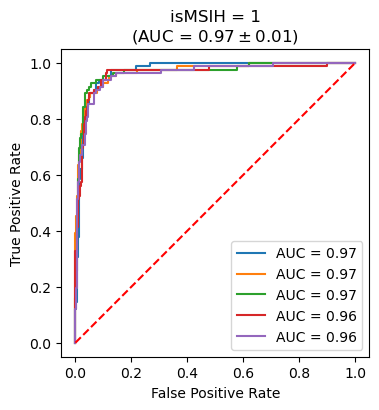

In [27]:
pred_dfs = [pd.read_csv(p, dtype=str) for p in pred_csvs]

y_trues = [df["ground_truth"] == f'{true_label:.1f}' for df in pred_dfs]
y_preds = [pd.to_numeric(df[f'logits']) for df in pred_dfs]
title = f'{cfg.target} = {true_label}'

fig, ax = plt.subplots(figsize=(4, 4))
if len(pred_dfs) == 1:
    plot_roc_curve(ax, y_trues[0], y_preds[0], title=title)
else:
    plot_roc_curves(ax, y_trues, y_preds, title=title)
#     fig.savefig(Path(output_path)/f'roc-{target_label}={true_label}.svg')
#     fig.savefig(output_path / f'auroc_{log_name}_{target_label}_{eval_name}.svg')
    # plt.close(fig)
plt.show()

[0.962124531424955, 0.9689158268828197, 0.9729321844116645, 0.9694269996592181, 0.9629764860522856]


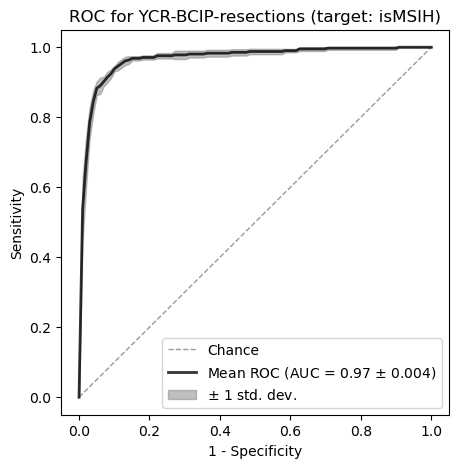

In [32]:
tprs = []
aucs = []
mean_fpr = np.linspace(0, 1, 100)


fig, ax = plt.subplots(figsize=(5, 5))

for i in range(len(y_trues)):
    fpr, tpr, _ = roc_curve(y_trues[i], y_preds[i])
    roc_auc = roc_auc_score(y_trues[i], y_preds[i])
    
#     ax.plot(fpr, tpr, label=f'AUC = {roc_auc:0.2f}', alpha=0.3, color='black')


    interp_tpr = np.interp(mean_fpr, fpr, tpr)
    interp_tpr[0] = 0.0
    tprs.append(interp_tpr)
    aucs.append(roc_auc)
print(aucs)
ax.plot([0, 1], [0, 1], linestyle="--", lw=1, color="gray", label="Chance", alpha=0.8)

mean_tpr = np.mean(tprs, axis=0)
mean_tpr[-1] = 1.0
mean_auc = auc(mean_fpr, mean_tpr)
std_auc = np.std(aucs)
# plot mean curve
ax.plot(
    mean_fpr,
    mean_tpr,
    color="black",
    label=r"Mean ROC (AUC = %0.2f $\pm$ %0.3f)" % (np.round(mean_auc, 2), np.round(std_auc, 3)),
    lw=2,
    alpha=0.8,
)

std_tpr = np.std(tprs, axis=0)
tprs_upper = np.minimum(mean_tpr + std_tpr, 1)
tprs_lower = np.maximum(mean_tpr - std_tpr, 0)
ax.fill_between(
    mean_fpr,
    tprs_lower,
    tprs_upper,
    color="grey",
    alpha=0.5,
    label=r"$\pm$ 1 std. dev.",
)

ax.set(
    xlim=[-0.05, 1.05],
    ylim=[-0.05, 1.05],
    title=f"ROC for {test_cohorts} (target: {cfg.target})",
)

ax.set_xlabel('1 - Specificity')
ax.set_ylabel('Sensitivity')

ax.legend(loc="lower right")
# fig.savefig(figure_path / f'auroc_{cfg.logging_name}_{test_cohorts}.svg', format='svg', bbox_inches = 'tight', pad_inches = 0)
plt.show()

In [ ]:
mean_auc, std_auc

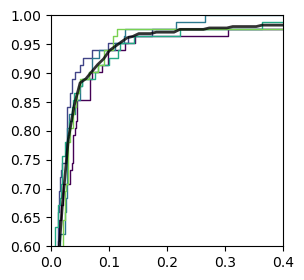

In [34]:
# plot zoom in
tprs = []
aucs = []
mean_fpr = np.linspace(0, 1, 100)


fig, ax = plt.subplots(figsize=(3,3))

for i in range(len(y_trues)):
    fpr, tpr, _ = roc_curve(y_trues[i], y_preds[i])
    roc_auc = roc_auc_score(y_trues[i], y_preds[i])
    
    ax.plot(fpr, tpr, lw=1, label=f'AUC = {roc_auc:0.2f}', color=pl.cm.viridis(i*(1/len(y_trues))))

    interp_tpr = np.interp(mean_fpr, fpr, tpr)
    interp_tpr[0] = 0.0
    tprs.append(interp_tpr)
    aucs.append(roc_auc)
ax.plot([0, 1], [0, 1], linestyle="--", lw=1, color="gray", label="Chance", alpha=0.8)

mean_tpr = np.mean(tprs, axis=0)
mean_tpr[-1] = 1.0
mean_auc = auc(mean_fpr, mean_tpr)
std_auc = np.std(aucs)
# plot mean curve
ax.plot(
    mean_fpr,
    mean_tpr,
    color="black",
    label=r"Mean ROC (AUC = %0.2f $\pm$ %0.3f)" % (mean_auc, std_auc),
    lw=2,
    alpha=0.8,
)

ax.set(
    xlim=[0., .4],
    ylim=[0.6, 1.],
)

# fig.savefig(figure_path / f'auroc_{cfg.logging_name}_{test_cohorts}_zoom.svg',  format='svg', bbox_inches = 'tight', pad_inches = 0)
plt.show()

## Plot PR curve

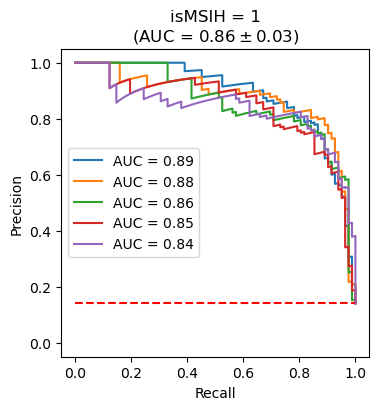

In [35]:
pred_dfs = [pd.read_csv(p, dtype=str) for p in pred_csvs]

y_trues = [df["ground_truth"] == f'{true_label:.1f}' for df in pred_dfs]
y_preds = [pd.to_numeric(df[f'logits']) for df in pred_dfs]
title = f'{cfg.target} = {true_label}'
fig, ax = plt.subplots(figsize=(4, 4))
if len(pred_dfs) == 1:
    plot_precision_recall_curve(ax, y_trues[0], y_preds[0], title=title)
else:
    plot_precision_recall_curves(ax, y_trues, y_preds, title=title)

# fig.savefig(Path(output_path)/f'prc_{log_name}_{target_label}={true_label}_{eval_name}.svg')
plt.show()

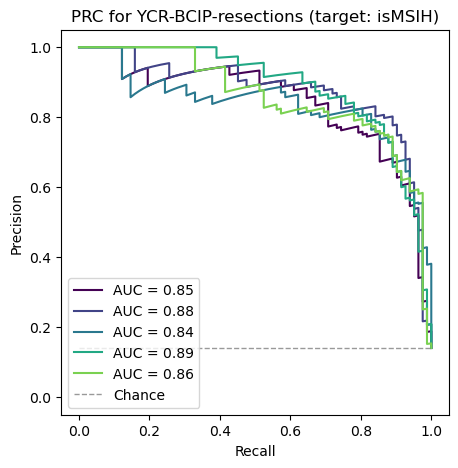

In [36]:
precs = []
aucs = []
mean_recall = np.linspace(0, 1, 100)

y_trues = [df["ground_truth"] == f'{true_label:.1f}' for df in pred_dfs]
y_preds = [pd.to_numeric(df[f'logits']) for df in pred_dfs]

fig, ax = plt.subplots(figsize=(5, 5))

for i in range(len(y_trues)):
    prec, rec, _ = precision_recall_curve(y_trues[i], y_preds[i])
    prec, rec = prec[::-1], rec[::-1]  # reverse order for interp
    pr_auc = average_precision_score(y_trues[i], y_preds[i])
    
    ax.plot(rec, prec, label=f'AUC = {pr_auc:0.2f}', color=pl.cm.viridis(i*(1/len(y_trues))))
    
    baseline = y_trues[i].sum()/len(y_trues[i])

    interp_prec = np.interp(mean_recall, rec, prec)
    interp_prec[0] = 0.0
    precs.append(interp_prec)
    aucs.append(pr_auc)
    
y_trues = np.concatenate(y_trues, dtype=int)
y_preds = np.concatenate(y_preds, dtype=float)
prec, rec, _ = precision_recall_curve(y_trues, y_preds)

pr_auc = average_precision_score(y_trues, y_preds)

ax.plot([0, 1], [baseline, baseline], '--', label="Chance", alpha=0.8, color="gray", lw=1)

ax.set(
    xlim=[-0.05, 1.05],
    ylim=[-0.05, 1.05],
    title=f"PRC for {test_cohorts} (target: {cfg.target})",
)

ax.set_xlabel('Recall')
ax.set_ylabel('Precision')

ax.legend(loc="lower left")
fig.savefig(figure_path / f'prauc_{cfg.logging_name}_{test_cohorts}.svg', format='svg', bbox_inches = 'tight', pad_inches = 0)
plt.show()

## Plot confusion matrix, analyze sensitifity and specificity

In [ ]:
# csv_dir = Path('/lustre/groups/peng/workspace/sophia.wagner/logs/genalt/outputs')

# model paths ---------------------------------------------------------------
# --- for MSI-H
# log_name = 'ctranspath_8epo_vit-cls_rand867_Dachs-Quasar-Rainbow-TCGA_macenko' # model for MSI-H
# log_name = 'histaugan_rand867_vit-cls_Dachs-Quasar-Rainbow-TCGA_histaugan' # histaugan model for MSI-H
# log_name = 'raw_rand867_vit-cls_Dachs-Quasar-Rainbow-TCGA_raw' # raw model for MSI-H
# --- for BRAF and KRAS
# log_name = 'ctranspath_8epo_vit-cls_Dachs-Quasar-Rainbow-TCGA_macenko'  # model for BRAF and KRAS
# --- for age < 50
# log_name = 'ctranspath_epo8_vit-cls_Dachs_macenko' # model for age < 50
# log_name = 'ctranspath_epo8_vit-cls_Quasar_macenko' # model for age < 50

# cohort for evaluation -------------------------------------------------------
# eval_name = 'Yorkshire-resections'
# eval_name_label = 'YCR-BCIP'
cmap = plt.cm.Blues
# eval_name = 'Yorkshire-biopsies'
# eval_name_label = 'YCR-BCIP-biopsies'
# cmap = plt.cm.Greens
# eval_name = 'Quasar'
# eval_name = 'Dachs'
# eval_name = 'Belfast'
# eval_name_label = 'Epi700'
# eval_name = 'KIEL-STAD'

# target label ---------------------------------------------------------------
target_label = 'isMSIH'
target_label_name = 'MSI-H'
# target_label = 'braf'
# target_label_name = 'BRAF'
# target_label = 'kras'
# target_label_name = 'KRAS'
true_label = 1

In [ ]:
# csv_paths = csv_dir.glob(f'outputs_{log_name}_{target_label}_fold*.csv')
# csv_paths = csv_dir.glob(f'outputs_{log_name}_{target_label}_fold*_eval_{eval_name}.csv')
# pred_csvs = list(csv_paths)
# pred_csvs = [csv_dir / f'outputs_{log_name}_{target_label}_fold{k}.csv' for k in range(5)]

In [ ]:
desired_sensitivity = 0.95

In [ ]:
# determine classification threshold on test data
thresholds_test = []
sensitivity = []
specificity = []
# Calculate the ROC curve
for k in range(5):
    fpr, tpr, thresholds = roc_curve(y_trues[k], y_preds[k])

    # Find the threshold for a desired sensitivity
    thresholds_test.append(thresholds[tpr >= desired_sensitivity][0])
    sensitivity.append(tpr[tpr >= desired_sensitivity][0])
    specificity.append(1-fpr[tpr >= desired_sensitivity][0])
#     print(1-fpr[tpr >= 0.95])

threshold_test = np.array(thresholds_test).mean()
# Print the threshold
print(f"Mean treshold for desired sensitivity of {desired_sensitivity:.2f}: {np.array(thresholds_test).mean():.4f}")
print(f"The model achieves sensitivity: {np.array(sensitivity).mean():.4f} with specificty {np.array(specificity).mean():.4f}")

In [ ]:
csv_paths = result_path.glob(f'fold*/outputs_{test_cohorts}.csv')
pred_csvs = list(csv_paths)

In [ ]:
csv_paths = result_path.glob(f'fold*/outputs_{test_cohorts}.csv')
pred_csvs = list(csv_paths)

In [ ]:
# determine best fold according to AUROC score
rocs = []
for i in range(len(y_trues)):
    rocs.append(roc_auc_score(y_trues[i], y_preds[i])) 
    # rocs.append(roc_auc_score(y_trues_train[i], y_preds_train[i]))
best_fold = np.argmax(rocs)
print(f'best fold: {best_fold}, with AUROC {rocs[best_fold]:.4f}')

In [ ]:
rocs

In [ ]:
desired_sensitivity = 0.9

In [ ]:
# determine classification threshold on test data
thresholds_train = []
sensitivity_indomain = []
specificity_indomain =[]

sensitivity = []
specificity =[]
# Calculate the ROC curve
for k in range(5):
    fpr_indomain, tpr_indomain, thresholds_indomain = roc_curve(y_trues_indomain[k], y_preds_indomain[k])
    fpr, tpr, thresholds = roc_curve(y_trues[k], y_preds[k])

    # Find the threshold for a desired sensitivity
    thresholds_train.append(thresholds_indomain[tpr_indomain >= desired_sensitivity][0])
    sensitivity_indomain.append(tpr_indomain[tpr_indomain >= desired_sensitivity][0])
    specificity_indomain.append(1-fpr_indomain[tpr_indomain >= desired_sensitivity][0])
    
    sensitivity.append(tpr[thresholds >= thresholds_train[k]][-1])
    specificity.append(1-fpr[thresholds >= thresholds_train[k]][-1])
    
threshold_train = np.array(thresholds_train).mean()
# Print the threshold
print(thresholds_train)
print(f"Mean treshold for desired sensitivity of {desired_sensitivity:.2f}: {np.array(thresholds_train).mean():.4f}")
print(f"Sensitivity (with in-domain threshold): {np.array(sensitivity_indomain).mean():.4f} with specificty {np.array(specificity_indomain).mean():.4f}")
print(f"Sensitivity (with external threshold): {np.array(sensitivity).mean():.4f} with specificty {np.array(specificity).mean():.4f}")

In [ ]:
npv = []
for k in range(5):
    tn, fp, fn, tp = confusion_matrix(y_trues[k], y_preds[k] > thresholds_train[k]).flatten()
    npv.append(tn / (tn + fn))
print(f"Negative predictive value (with in-domain threshold): {np.array(npv).mean():.4f}")

In [ ]:
npv = []
for k in range(5):
    tn, fp, fn, tp = confusion_matrix(y_trues[k], y_preds[k] > thresholds_test[k]).flatten()
    npv.append(tn / (tn + fn))
print(f"Negative predictive value (with external threshold): {np.array(npv).mean():.4f}")

In [ ]:
threshold_train, threshold_test

In [ ]:
# determine negative predictive value
print(f"Negative predictive value (with in-domain threshold): {np.array(specificity_indomain).mean()/(1-np.array(sensitivity_indomain).mean()):.4f}")
print(f"Negative predictive value (with external threshold): {np.array(specificity).mean()/(1-np.array(sensitivity).mean()):.4f}")

## determine thresholds for each fold

In [ ]:
# determine classification threshold on in-domain test data
best_thresholds = []
# choose threshold according to desired sensitivity or geometric mean
desired_sensitivity = 0.9

for k in range(5):
    # in-domain test set
    fpr, tpr, thresholds = roc_curve(y_trues_indomain[k], y_preds_indomain[k])
    
    if desired_sensitivity:
        best_threshold = thresholds[tpr >= desired_sensitivity][0]
    else:
        gm = np.sqrt(tpr * (1 - fpr))
        best_threshold = thresholds[np.argmax(gm)]

    best_thresholds.append(best_threshold)
    
print(best_thresholds)


In [ ]:
sensitivity = []
specificity = []
precision = []
npv = []

# threshold = [0.6940] * 5
# threshold = [0.5] * 5
threshold = best_thresholds
for k in range(5):
    tn, fp, fn, tp = confusion_matrix(y_trues_indomain[k], y_preds_indomain[k] > threshold[k]).ravel()
    sensitivity.append(tp / (tp + fn))  # recall
    specificity.append(tn / (tn + fp))
    precision.append(tp / (tp + fp))
    npv.append(tn / (tn + fn))

print("In-domain test set")
print(f"Mean treshold: {np.mean(threshold):.3f} with thresholds in each fold: {threshold}")
print(f"Sensitivity {np.mean(sensitivity):.3f} ({np.std(sensitivity):.4f}) with specificty {np.mean(specificity):.3f} ({np.std(specificity):.4f})")
print(f"Negative predictive value: {np.mean(npv):.3f} ({np.std(npv):.4f})")
print(f"Precision: {np.mean(precision):.3f} ({np.std(precision):.4f})")

In [ ]:
# load evaluation cohort
# test_cohorts = 'CHINA' 
# test_cohorts = 'Epi700' 
test_cohorts = 'MAINZ'
# test_cohorts = 'YCR-BCIP-resections'
# test_cohorts = 'YCR-BCIP-biopsies'

csv_paths = result_path.glob(f'fold*/outputs_{test_cohorts}.csv')
pred_csvs = list(csv_paths)
pred_dfs = [pd.read_csv(p, dtype=str) for p in pred_csvs]

y_trues = [df['ground_truth'] == f'{true_label:.1f}' for df in pred_dfs]
y_preds = [pd.to_numeric(df[f'logits']) for df in pred_dfs]

In [ ]:
sensitivity = []
specificity = []
precision = []
npv = []

# threshold = [0.6940] * 5
# threshold = [0.5] * 5
threshold = best_thresholds
for k in range(5):
    tn, fp, fn, tp = confusion_matrix(y_trues[k], y_preds[k] > threshold[k]).ravel()
    sensitivity.append(tp / (tp + fn))  # recall
    specificity.append(tn / (tn + fp))
    precision.append(tp / (tp + fp))
    npv.append(tn / (tn + fn))

print(f"{test_cohorts} test set")
print(f"Mean treshold: {np.mean(threshold):.3f} with thresholds in each fold: {threshold}")
print(f"Sensitivity {np.mean(sensitivity):.3f} ({np.std(sensitivity):.4f}) with specificty {np.mean(specificity):.3f} ({np.std(specificity):.4f})")
print(f"Negative predictive value: {np.mean(npv):.3f} ({np.std(npv):.4f})")
print(f"Precision: {np.mean(precision):.3f} ({np.std(precision):.4f})")


In [ ]:
specificity

In [ ]:
# Define the class labels
labels = ["non MSIH", "MSIH"]

# Calculate the confusion matrix for different classification thresholds
# thresholds_test = np.array(thresholds_test).mean().repeat(5)
# thresholds_train = np.array(thresholds_train).mean().repeat(5)
thresholds = [thresholds_test, [0.25] * 5, [0.5] * 5, [0.75] * 5, thresholds_train]

# Plot the confusion matrices
fig, axs = plt.subplots(1, len(thresholds), figsize=(12,10), gridspec_kw={'width_ratios': [4, 4, 4, 4, 4.4]})
for ax, threshold in zip(axs.flatten(), thresholds):
    cm = []
    for k in range(5):
        cm.append(confusion_matrix(y_trues[k], y_preds[k] > threshold[k]))
    cm = np.stack(cm, axis=0).mean(axis=0)    
    print(threshold[k])
#     cm = confusion_matrix(y_trues[best_fold], y_preds[best_fold] > threshold)

    # Normalize the confusion matrices by the row
    cm_normalized = cm.astype("float") / cm.sum(axis=1)[:, np.newaxis]
    cm_perc = cm.astype("float") / cm.sum(axis=(0, 1))[np.newaxis, np.newaxis]

    im = ax.imshow(cm_normalized, interpolation='nearest', cmap=cmap)
    ax.set(xticks=np.arange(cm.shape[1]),
           yticks=np.arange(cm.shape[0]),
           xticklabels=labels, yticklabels=labels,
           title=f"Threshold = {threshold[k]:.2f}",
#            ylabel='True label',
           xlabel='Predicted label')
    ax.set_yticklabels(labels, rotation='vertical', va='center', ha='center')
    for i in range(cm.shape[0]):
        for j in range(cm.shape[1]):
            color = "w" if cm_normalized[i, j] > 0.5 else "k"
            ax.text(j, i, int(cm[i, j].round()), ha="center", va="bottom", color=color)
            ax.text(j, i, f'{cm_normalized[i, j]*100:.01f}%', ha="center", va="top", color=color)
#             ax.text(j, i, f'{cm_perc[i, j]*100:.01f}%', ha="center", va="top", color=color)

cbar = fig.colorbar(im, ax=axs[-1], fraction=0.046, pad=0.04, ticks=[0.02, 0.2, 0.4, 0.6, 0.8, 0.98])
cbar.ax.set_yticklabels(np.linspace(0, 1, 6, dtype=np.float16))  # horizontal colorbar
axs[0].set(ylabel='True label')
axs[0].set(title='External threshold')
axs[-1].set(title='In-domain threshold')
# plt.tight_layout()
fig.savefig(output_path / f'confusion_matrices_{log_name}_{target_label}_{eval_name}_mean.svg',  format='svg', bbox_inches = 'tight', pad_inches = 0)
plt.show()

In [ ]:
cm.astype("float") / cm.sum(axis=(0, 1))[np.newaxis, np.newaxis]


In [ ]:
np.array(thresholds_test).mean().repeat(5)

In [ ]:
# Define the class labels
labels = ["non MSIH", "MSIH"]

# Calculate the confusion matrix for different classification thresholds
# threshsolds = [np.array(thresholds_test).mean()]
thresholds = [thresholds_test, [0.25] * 5, [0.5] * 5, [0.75] * 5, thresholds_train]

# Plot the confusion matrices
fig, axs = plt.subplots(5, len(thresholds), figsize=(12,15), gridspec_kw={'width_ratios': [4, 4, 4, 4, 4.4]})
for k in range(5):
    for t in range(5):
        cm = confusion_matrix(y_trues[k], y_preds[k] > thresholds[t][k])
        print(t, k, thresholds[t][k], cm.sum(axis=1))

        # Normalize the confusion matrices by the row
        cm_normalized = cm.astype("float") / cm.sum(axis=1)[:, np.newaxis]

        im = axs[k, t].imshow(cm_normalized, interpolation='nearest', cmap=cmap)
        axs[k, t].set(xticks=np.arange(cm.shape[1]),
               yticks=np.arange(cm.shape[0]),
               xticklabels=labels, yticklabels=labels,
               title=f"Threshold = {thresholds[t][k]:.2f}",
    #            ylabel='True label',
               xlabel='Predicted label')
        axs[k, t].set_yticklabels(labels, rotation='vertical', va='center', ha='center')
        for i in range(cm.shape[0]):
            for j in range(cm.shape[1]):
                color = "w" if cm_normalized[i, j] > 0.5 else "k"
                axs[k, t].text(j, i, int(cm[i, j].round()), ha="center", va="bottom", color=color)
                axs[k, t].text(j, i, f'{cm_normalized[i, j]*100:.01f}%', ha="center", va="top", color=color)

    cbar = fig.colorbar(im, ax=axs[k, 4], fraction=0.046, pad=0.04, ticks=[0.02, 0.2, 0.4, 0.6, 0.8, 0.98])
    cbar.ax.set_yticklabels(np.linspace(0, 1, 6, dtype=np.float16))  # horizontal colorbar
    axs[k, 0].set(ylabel='True label')
    axs[k, 0].set(title=f'Ext. thresh. ({thresholds[0][k]:.03f})')
    axs[k, 4].set(title=f'In-dom. thresh. ({thresholds[4][k]:.03f})')
# plt.tight_layout()
fig.savefig(output_path / f'confusion_matrices_{log_name}_{target_label}_{eval_name}_all_folds.svg',  format='svg', bbox_inches = 'tight', pad_inches = 0)
plt.show()

In [ ]:
thresholds_test

In [ ]:
fig = plt.figure(figsize=(10, 5))
# Split the predictions and labels by label
preds_0 = y_preds[best_fold][y_trues[best_fold] == 0]
preds_1 = y_preds[best_fold][y_trues[best_fold] == 1]

# Plot the histograms
plt.hist([preds_0, preds_1], bins=50, density=True, label=["nonMSIH", "MSIH"])
# plt.hist([preds_0, preds_1], bins=50, density=False, label=["nonMSIH", "MSIH"], alpha=0.2)
plt.xlabel("Prediction")
plt.ylabel("Density")
plt.legend()
plt.tight_layout()
plt.show()

In [ ]:
num_folds = 5

# Set up the subplots
fig, axs = plt.subplots(1, num_folds, figsize=(num_folds * 5, 5))

# Plot the histograms for each model
for k, ax, in enumerate(axs):
    preds_0 = y_preds[k][y_trues[k] == 0]
    preds_1 = y_preds[k][y_trues[k] == 1]
    
    ax.hist([preds_0, preds_1], bins=50, density=True, label=["nonMSIH", "MSIH"])
    ax.set_xlabel("Prediction")
    ax.set_ylabel("Density")
    ax.legend()

In [ ]:
y_trues

### compute missing statistics

In [ ]:
pred_dfs = [pd.read_csv(p, dtype=str) for p in pred_csvs]

y_trues = [df['ground_truth'] == f'{true_label:.1f}' for df in pred_dfs]
y_preds = [pd.to_numeric(df[f'logits']) for df in pred_dfs]

In [ ]:
pr_auc = []
# Compute AUPRC mean and std
for i in range(len(y_trues)):
    prec, rec, _ = precision_recall_curve(y_trues[i], y_preds[i])
    prec, rec = prec[::-1], rec[::-1]  # reverse order for interp
    pr_auc.append(average_precision_score(y_trues[i], y_preds[i]))
    
np.mean(pr_auc), np.std(pr_auc)


## plot num samples curves

In [ ]:
# dir_path = Path('/lustre/groups/peng/workspace/sophia.wagner/logs/genalt/results')
dir_path = Path('/home/haicu/sophia.wagner/projects/genetic_alteration_prediction')
ext_cohort = 'Yorkshire_resections'
# ext_cohort = 'Yorkshire_biopsies'
model = 'transformer'
feats = 'ctranspath'
# ext_cohort = 'Yorkshire_resections'
filename = dir_path / f'MSI_prediction_num_samples_{ext_cohort}_{model}_{feats}.csv'
num_df = pd.read_csv(filename)

In [ ]:
#             # save results in data frame 
#             for ext_cohort in ext_cohorts:
#                 results_csv = result_path / f'results_num_samples_{ext_cohort}_{args.model}_{args.feats}{args.name}.csv'
#                 columns = ["num samples"] + [f'fold {i}' for i in range(5)]
#                 new_results = pd.DataFrame(data=np.array([[n, *ext_auc_dict[ext_cohort][n]]]), columns=columns)

#                 # append results to existing results data frame
#                 if results_csv.is_file():
#                     results_df = pd.read_csv(results_csv, dtype=str)
#                     if n in results_df["num samples"]:
#                         continue
#                     else:
#                         results_df = results_df.append(new_results)
#                 else:
#                     results_df = new_results

#                 results_df.to_csv(results_csv, sep=',', index=False)

In [ ]:
# cohort for evaluation
# ext_cohort = 'Yorkshire-resections'
ext_cohort = 'Yorkshire-biopsies'

In [ ]:
model = 'vit-cls'
feats = 'ctranspath'
name = ''

label = 'Macenko'

result_path = Path('/lustre/groups/peng/workspace/sophia.wagner/logs/genalt/results')
filename = result_path / f'results_num_samples_{ext_cohort}_{model}_{feats}{name}.csv'

num_df = pd.read_csv(filename)
num_df = num_df.rename({'fold 4 ': 'fold 4'}, axis=1)
num_df = num_df.rename({'training samples': 'num samples'}, axis=1)
num_df = num_df.sort_values(by='num samples')
num_df = num_df.drop_duplicates(subset='num samples')
num_samples_array = [num_df[f'fold {i}'].values for i in range(5)]
num_samples_x = num_df['num samples'].values

In [ ]:
# model = 'attmil'
model = 'vit-cls'
feats = 'ctranspath'
name = '_histaugan'

label2 = 'HistAuGAN'

filename = result_path / f'results_num_samples_{ext_cohort}_{model}_{feats}{name}.csv'

num_df2 = pd.read_csv(filename)
num_df2 = num_df2.rename({'fold 4 ': 'fold 4'}, axis=1)
num_df2 = num_df2.rename({'training samples': 'num samples'}, axis=1)
num_df2 = num_df2.sort_values(by='num samples')
num_df2 = num_df2.drop_duplicates(subset='num samples')
num_samples_array2 = [num_df2[f'fold {i}'].values for i in range(5)]
num_samples_x2 = num_df2['num samples'].values

In [ ]:
num_df2

In [ ]:
plt.figure(figsize=(5, 5))
# plt.boxplot(np.stack(num_samples_array), labels=np.array(num_df['num_samples'], dtype=float), widths=0.2, showmeans=True, meanline=True)
# for i in range(5):
#     plt.scatter(np.array(num_df['num_samples'], dtype=float), np.stack(num_samples_array)[i])
# plt.plot(range(1, 16), np.mean(np.stack(num_samples_array), axis=0))

plt.plot((0, 10000), (0.9, 0.9), linewidth=0.5, color='gray')
plt.plot((0, 10000), (0.95, 0.95), linewidth=0.5, color='gray')
# plt.plot((0, 10000), (0.95, 0.95), linestyle='--', linewidth=1, color='gray')


num_samples = np.stack(num_samples_array)
mean = num_samples.mean(axis=0)
std = num_samples.std(axis=0)
plt.plot(num_samples_x, mean, color='tab:blue', label=label)
plt.plot((0, 10000), (0.9686, 0.9686), linestyle='--', linewidth=1, color='tab:blue', label='Best model')
# plt.plot((0, 10000), (0.9072, 0.9072), linestyle='--', linewidth=1, color='tab:blue', label='Best model')
plt.plot(num_samples_x, num_samples[0], alpha=0.3, color='tab:blue')
plt.plot(num_samples_x, num_samples[1], alpha=0.3, color='tab:blue')
plt.plot(num_samples_x, num_samples[2], alpha=0.3, color='tab:blue')
plt.plot(num_samples_x, num_samples[3], alpha=0.3, color='tab:blue')
plt.plot(num_samples_x, num_samples[4], alpha=0.3, color='tab:blue')
plt.fill_between(num_samples_x, mean - std, mean + std, alpha=0.5, color='tab:blue')


num_samples = np.stack(num_samples_array2)
mean = num_samples.mean(axis=0)
std = num_samples.std(axis=0)
plt.plot(num_samples_x2, mean, color='tab:orange', label=label2)
# plt.plot((0, 8000), (0.9633, 0.9633), linestyle='--', linewidth=1, color='tab:orange', label='Best model')
plt.plot(num_samples_x2, num_samples[0], alpha=0.3, color='tab:orange')
plt.plot(num_samples_x2, num_samples[1], alpha=0.3, color='tab:orange')
plt.plot(num_samples_x2, num_samples[2], alpha=0.3, color='tab:orange')
plt.plot(num_samples_x2, num_samples[3], alpha=0.3, color='tab:orange')
plt.plot(num_samples_x2, num_samples[4], alpha=0.3, color='tab:orange')
plt.fill_between(num_samples_x2, mean - std, mean + std, alpha=0.6, color='tab:orange')

plt.legend(loc="lower right")
plt.ylim(0.5, 1)
plt.yticks(ticks=np.linspace(0.5, 1, 11))
plt.ylabel('AUROC')

plt.xlim(min(num_samples_x)-2, max(num_samples_x)+2000)
plt.xticks(ticks=num_samples_x, labels=[x for x in num_samples_x])
plt.xscale('log')
plt.xlabel('Number of samples in the training set (log scale)')

# plt.savefig(output_path / f'num_samples_{ext_cohort}.svg', format='svg', bbox_inches = 'tight', pad_inches = 0)

plt.show()

In [ ]:
num_samples = np.stack(num_samples_array)
mean = num_samples.mean(axis=0)
std = num_samples.std(axis=0)

In [ ]:
mean

In [ ]:
std

In [ ]:
num_samples = np.stack(num_samples_array)
mean = num_samples.mean(axis=0)

In [ ]:
mean, num_samples_x

In [ ]:
num_samples = np.stack(num_samples_array2)
mean = num_samples.mean(axis=0)

In [ ]:
mean, num_samples_x

In [ ]:
t_ctp_n = np.array([50, 100, 250, 500, 1000, 1500, 2000, 2500, 3000, 3500, 4000, 4500, 5000, 5500, 6000, 6500, 7000, 7500, 8000])
t_ctp = np.array([
    [0.7652, 0.8778, 0.7515, 0.7836, 0.8378,],
    [0.8041, 0.8283, 0.9115, 0.7765, 0.7524,],
    [0.9340, 0.9329, 0.8734, 0.9070, 0.9298,],
    [0.9313, 0.9485, 0.9064, 0.8828, 0.9169,],
    [0.9601, 0.9477, 0.9599, 0.9544, 0.9588,],
    [0.9452, 0.9513, 0.9575, 0.9680, 0.9475,],
    [0.9634, 0.9727, 0.9631, 0.9518, 0.9489,],
    [0.9676, 0.9677, 0.9551, 0.9600, 0.9635,],
    [0.9583, 0.9637, 0.9565, 0.9655, 0.9591,],
    [0.9619, 0.9637, 0.9707, 0.9633, 0.9654,],
    [0.9657, 0.9573, 0.9683, 0.9726, 0.9583,],
    [0.9647, 0.9672, 0.9729, 0.9700, 0.9651,],
    [0.9668, 0.9768, 0.9703, 0.9613, 0.9647,],
    [0.9669, 0.9682, 0.9604, 0.9667, 0.9594,],
    [0.9728, 0.9702, 0.9682, 0.9746, 0.9663,],
    [0.9636, 0.9646, 0.9696, 0.9785, 0.9730,],
    [0.9709, 0.9702, 0.9705, 0.9781, 0.9679,],
    [0.9724, 0.9662, 0.9677, 0.9711, 0.9741,],
    [0.9692, 0.9684, 0.9706, 0.9590, 0.9686,],
])

In [ ]:
num_samples = t_ctp
mean = num_samples.mean(axis=1)
std = num_samples.std(axis=1)
plt.plot(t_ctp_n, mean)
plt.plot(t_ctp_n, num_samples[:, 0], alpha=0.2)
plt.plot(t_ctp_n, num_samples[:, 1], alpha=0.2)
plt.plot(t_ctp_n, num_samples[:, 2], alpha=0.2)
plt.plot(t_ctp_n, num_samples[:, 3], alpha=0.2)
plt.plot(t_ctp_n, num_samples[:, 4], alpha=0.2)
plt.fill_between(t_ctp_n, mean - std, mean + std, alpha=0.5)

# plt.xlim(1, num_samples.shape[1]+1)
plt.xticks(ticks=t_ctp_n) # labels=[x for x in range(500, num_samples.shape[1]*500+1, 500)])
plt.xscale('log')
plt.show()

In [ ]:
num_samples = t_ctp
mean = num_samples.mean(axis=1)
std = num_samples.std(axis=1)
plt.plot(t_ctp_n, mean)
plt.plot(t_ctp_n, num_samples[:, 0], alpha=0.2)
plt.plot(t_ctp_n, num_samples[:, 1], alpha=0.2)
plt.plot(t_ctp_n, num_samples[:, 2], alpha=0.2)
plt.plot(t_ctp_n, num_samples[:, 3], alpha=0.2)
plt.plot(t_ctp_n, num_samples[:, 4], alpha=0.2)
plt.fill_between(t_ctp_n, mean - std, mean + std, alpha=0.5)

# plt.xlim(1, num_samples.shape[1]+1)
plt.xticks(ticks=t_ctp_n) # labels=[x for x in range(500, num_samples.shape[1]*500+1, 500)])
plt.xscale('log')
plt.show()

In [ ]:
# Import module for data manipulation
import pandas as pd
# Import module for linear algebra
import numpy as np
# Import module for data simulation
from sklearn.datasets import make_classification     # Create a synthetic dataframe
from sklearn.linear_model import LogisticRegression  # Classification model
from sklearn.model_selection import train_test_split # Split the dataframe
from sklearn.metrics import roc_curve                # Calculate the ROC curve
from sklearn.metrics import precision_recall_curve   # Calculate the Precision-Recall curve
from sklearn.metrics import f1_score                 # Calculate the F-score
# Import module for data visualization
from plotnine import *
import plotnine

# Generate the dataset
X, y = make_classification(n_samples = 10000, n_features = 2, n_redundant = 0,
                           n_clusters_per_class = 1, weights = [0.99], flip_y = 0, random_state = 0)

# Data partitioning
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.5, random_state=0, stratify=y)

# Fit the model
reglogModel = LogisticRegression(random_state = 0)
reglogModel.fit(X_train, y_train)

# Predict the probabilities
y_pred = reglogModel.predict_proba(X_test)

# Get the probabilities for positive class
y_pred = y_pred[:, 1]

In [ ]:
# Create the ROC curve
fpr, tpr, thresholds = roc_curve(y_test, y_pred)

# Plot the ROC curve
df_fpr_tpr = pd.DataFrame({'FPR':fpr, 'TPR':tpr, 'Threshold':thresholds})
df_fpr_tpr.head()

# Create the data viz
plotnine.options.figure_size = (8, 4.8)
(
    ggplot(data = df_fpr_tpr)+
    geom_point(aes(x = 'FPR',
                   y = 'TPR'),
               size = 0.4)+
    geom_line(aes(x = 'FPR',
                  y = 'TPR'))+
    labs(title = 'ROC Curve')+
    xlab('False Positive Rate')+
    ylab('True Positive Rate')+
    theme_minimal()
)

In [ ]:
# Calculate the G-mean
gmean = np.sqrt(tpr * (1 - fpr))

# Find the optimal threshold
index = np.argmax(gmean)
thresholdOpt = round(thresholds[index], ndigits = 4)
gmeanOpt = round(gmean[index], ndigits = 4)
fprOpt = round(fpr[index], ndigits = 4)
tprOpt = round(tpr[index], ndigits = 4)
print('Best Threshold: {} with G-Mean: {}'.format(thresholdOpt, gmeanOpt))
print('FPR: {}, TPR: {}'.format(fprOpt, tprOpt))

# Create data viz
plotnine.options.figure_size = (8, 4.8)
(
    ggplot(data = df_fpr_tpr)+
    geom_point(aes(x = 'FPR',
                   y = 'TPR'),
               size = 0.4)+
    # Best threshold
    geom_point(aes(x = fprOpt,
                   y = tprOpt),
               color = '#981220',
               size = 4)+
    geom_line(aes(x = 'FPR',
                  y = 'TPR'))+
    geom_text(aes(x = fprOpt,
                  y = tprOpt),
              label = 'Optimal threshold \n for class: {}'.format(thresholdOpt),
              nudge_x = 0.14,
              nudge_y = -0.10,
              size = 10,
              fontstyle = 'italic')+
    labs(title = 'ROC Curve')+
    xlab('False Positive Rate (FPR)')+
    ylab('True Positive Rate (TPR)')+
    theme_minimal()
)

In [ ]:
# Calculate the sensitivity threshold
sensitivity_thresh = 0.90

# Find the optimal threshold
index = np.argwhere(tpr >= sensitivity_thresh)[0].item()
thresholdOpt = round(thresholds[index], ndigits = 4)
gmeanOpt = round(gmean[index], ndigits = 4)
fprOpt = round(fpr[index], ndigits = 4)
tprOpt = round(tpr[index], ndigits = 4)
print('Best Threshold: {} with G-Mean: {}'.format(thresholdOpt, gmeanOpt))
print('FPR: {}, TPR: {}'.format(fprOpt, tprOpt))

# Create data viz
plotnine.options.figure_size = (8, 4.8)
(
    ggplot(data = df_fpr_tpr)+
    geom_point(aes(x = 'FPR',
                   y = 'TPR'),
               size = 0.4)+
    # Best threshold
    geom_point(aes(x = fprOpt,
                   y = tprOpt),
               color = '#981220',
               size = 4)+
    geom_line(aes(x = 'FPR',
                  y = 'TPR'))+
    geom_text(aes(x = fprOpt,
                  y = tprOpt),
              label = 'Optimal threshold \n for class: {}'.format(thresholdOpt),
              nudge_x = 0.14,
              nudge_y = -0.10,
              size = 10,
              fontstyle = 'italic')+
    labs(title = 'ROC Curve')+
    xlab('False Positive Rate (FPR)')+
    ylab('True Positive Rate (TPR)')+
    theme_minimal()
)

In [ ]:
thresholds

In [ ]:
index

In [ ]:
tpr[tpr >= 0.9]

In [ ]:
tpr[tpr >= 0.9][0]

In [ ]:
np.argwhere(tpr >= 0.9)

In [ ]:
np.argwhere(tpr >= 0.9)[0].item()

In [ ]:
thresholds[np.where(tpr == tpr[tpr >= 0.9][0])[0][0]]

In [ ]:
d = {'key':3}, {'te': 45
               }

In [ ]:
d

# Data stats

In [ ]:
from tqdm import tqdm
import h5py
import torch

from data_utils import MSI_cohorts_munich

## Class distribution

In [ ]:
cohorts = ["Belfast", "CPTAC", "Dachs", "Duessel", "MECC", "Munich", "Quasar", "Rainbow", "TCGA", "Yorkshire-biopsies", "Yorkshire-resections"]
targets = ['', 'isMSIH', 'braf', 'kras']
categories = ['Not mut.', 'Mutat.', 'nonMSIH', 'MSIH', 'WT', 'MUT', 'wt', 'MT']
norm = "macenko"
feats = "ctranspath"

In [ ]:
for cohort in cohorts:
    cohort_dict = {}
    for target in targets:
        clini_table = MSI_cohorts_munich[cohort]['clini_table']
        slide_csv = MSI_cohorts_munich[cohort]['slide_csv']
        feature_dir = MSI_cohorts_munich[cohort]['feature_dir'][norm][feats]
        
        clini_df = pd.read_csv(clini_table, dtype=str) if Path(clini_table).suffix == '.csv' else pd.read_excel(
            clini_table, dtype=str)
        slide_df = pd.read_csv(slide_csv, dtype=str)
        df = clini_df.merge(slide_df, on='PATIENT')
        # adapt dataframe to case sensitive clini tables
        df = df.rename({
            'MSI': 'isMSIH',
            'BRAF': 'braf', 'BRAF_mutation': 'braf', 'braf_status': 'braf', 
            'KRAS': 'kras', 'kras_status': 'kras', 'KRAS_mutation': 'kras',
            'NRAS': 'nras', 'NRAS_mutation': 'nras',  
        }, axis=1)

        # remove columns not in target_labels
        for key in df.columns:
            keys = [target] + ['PATIENT', 'SLIDE', 'FILENAME'] if target != '' else ['PATIENT', 'SLIDE', 'FILENAME']
            if key not in keys:
                df.drop(key, axis=1, inplace=True)
        # remove rows/slides with non-valid labels
        if target == '' or target in df.keys():
            if target != '':
                for target in [target]:
                    df = df[df[target].isin(categories)]
    #         if self.clini_info:
    #             df = df[df['GENDER'].isin(['female', 'male'])]
    #             df = df[df['AGE'].str.isdigit()]
    #             df = df[df['LEFT_RIGHT'].isin(['left', 'right'])]
            # remove slides we don't have
            h5s = set(feature_dir.glob('*.h5'))
            assert h5s, f'no features found in {feature_dir}!'
            h5_df = pd.DataFrame(h5s, columns=['slide_path'])
            # h5_df['FILENAME'] = h5_df.slide_path.map(lambda p: p.stem.split('.')[0])
            h5_df['FILENAME'] = h5_df.slide_path.map(lambda p: p.stem.split('.')[0]) if cohort=='TCGA' else h5_df.slide_path.map(lambda p: p.stem)
            df = df.merge(h5_df, on='FILENAME')

            # reduce to one row per patient with list of slides in `df['slide_path']`
            patient_df = df.groupby('PATIENT').first().drop(columns='slide_path')
            patient_slides = df.groupby('PATIENT').slide_path.apply(list)
            df = patient_df.merge(patient_slides, left_on='PATIENT', right_index=True).reset_index()

            if target != '':
                assert len(df[target].unique()) == 2
                pos_key = df[target].unique()[0] if df[target].unique()[0] in ['Mutat.', 'MSIH', 'MUT', 'MT'] else df[target].unique()[1]
                pos = df[target].value_counts()[pos_key]
            cohort_dict[target] = {
                "num": len(df),
                "pos": pos if target != '' else len(df)
            }
        else: 
            cohort_dict[target] = {
                "num": 0,
                "pos": 0
            }
            
    print(f"{cohort: <20}: total: {cohort_dict['']['num']}, \
          isMSIH: {cohort_dict['isMSIH']['pos']} / {cohort_dict['isMSIH']['num']}, \
          braf: {cohort_dict['braf']['pos']} / {cohort_dict['braf']['num']}, \
          kras: {cohort_dict['kras']['pos']} / {cohort_dict['kras']['num']}")

## Tile distribution

In [ ]:
cohorts = ["Belfast", "CPTAC", "Dachs", "Duessel", "MECC", "Munich", "Quasar", "Rainbow", "TCGA", "Yorkshire-biopsies", "Yorkshire-resections"]
target = 'isMSIH'
categories = ['Not mut.', 'Mutat.', 'nonMSIH', 'MSIH', 'WT', 'MUT', 'wt', 'MT']
norm = "macenko"
feats = "ctranspath"

In [ ]:
cohort_dict = {}
for cohort in cohorts:
    num_tiles = []

    clini_table = MSI_cohorts_munich[cohort]['clini_table']
    slide_csv = MSI_cohorts_munich[cohort]['slide_csv']
    feature_dir = MSI_cohorts_munich[cohort]['feature_dir'][norm][feats]

    clini_df = pd.read_csv(clini_table, dtype=str) if Path(clini_table).suffix == '.csv' else pd.read_excel(
        clini_table, dtype=str)
    slide_df = pd.read_csv(slide_csv, dtype=str)
    df = clini_df.merge(slide_df, on='PATIENT')
    # adapt dataframe to case sensitive clini tables
    df = df.rename({
        'MSI': 'isMSIH',
        'BRAF': 'braf', 'BRAF_mutation': 'braf', 'braf_status': 'braf', 
        'KRAS': 'kras', 'kras_status': 'kras', 'KRAS_mutation': 'kras',
        'NRAS': 'nras', 'NRAS_mutation': 'nras',  
    }, axis=1)

    # remove columns not in target_labels
    for key in df.columns:
        keys = [target] + ['PATIENT', 'SLIDE', 'FILENAME'] if target != '' else ['PATIENT', 'SLIDE', 'FILENAME']
        if key not in keys:
            df.drop(key, axis=1, inplace=True)
    # remove rows/slides with non-valid labels
    df = df[df[target].isin(categories)]
    # remove slides we don't have
    h5s = set(feature_dir.glob('*.h5'))
    assert h5s, f'no features found in {feature_dir}!'
    h5_df = pd.DataFrame(h5s, columns=['slide_path'])
    # h5_df['FILENAME'] = h5_df.slide_path.map(lambda p: p.stem.split('.')[0])
    h5_df['FILENAME'] = h5_df.slide_path.map(lambda p: p.stem.split('.')[0]) if cohort=='TCGA' else h5_df.slide_path.map(lambda p: p.stem)
    df = df.merge(h5_df, on='FILENAME')

    # reduce to one row per patient with list of slides in `df['slide_path']`
    patient_df = df.groupby('PATIENT').first().drop(columns='slide_path')
    patient_slides = df.groupby('PATIENT').slide_path.apply(list)
    df = patient_df.merge(patient_slides, left_on='PATIENT', right_index=True).reset_index()

    assert len(df[target].unique()) == 2

    # count tiles 
    for p in tqdm(range(len(df))):
        fpath = df.slide_path[p][0]
        h5_file = h5py.File(fpath)
        features = torch.Tensor(np.array(h5_file['feats'])).unsqueeze(0)
        num_tiles.append(features.shape[1])
    
    cohort_dict[cohort] = num_tiles

In [ ]:
for cohort in cohorts:
    num_tiles = np.array(cohort_dict[cohort])
    print(cohort, num_tiles.mean().round(), num_tiles.std().round(), num_tiles.min(), num_tiles.max())

In [ ]:
res = {
    "CPTAC": "CPTAC", 
    "Dachs" : "DACHS", 
    "Duessel": "DUSSEL", 
    "Belfast": "Epi700", 
    "MECC": "MECC", 
    "Munich": "MUNICH", 
    "Rainbow": "NLCS", 
    "Quasar": "QUASAR", 
    "TCGA": "TCGA", 
    "Yorkshire-resections": "YCR-BCIP"
}
res_revers = dict((v, k) for k, v in res.items())
bio = {"Yorkshire-biopsies": "YCR-BCIP-biopsies"}

In [ ]:
rows, columns, img_size = 2, 5, 3
plt.figure(figsize=(columns * img_size, rows * img_size))
for i, cohort in enumerate(res_revers.keys()):
    num_tiles = np.array(cohort_dict[res_revers[cohort]])

    plt.subplot(rows, columns, i + 1)
    if cohort == "MUNICH":
        plt.yticks(range(0, 21, 5))
    plt.hist(num_tiles, bins=50)
    plt.axvline(x=num_tiles.mean(), color='tab:orange', label=int(num_tiles.mean().round()))
    plt.xlim([-300, 12500])
    plt.xlabel('Number of tiles')
    plt.ylabel('Number of slides')
    plt.title(cohort)
    plt.legend()
plt.tight_layout()
plt.savefig(output_path / f'num_tiles_resections.svg',  format='svg', bbox_inches = 'tight', pad_inches = 0)

In [ ]:
rows, columns, img_size = 1, 1, 3
plt.figure(figsize=(columns * img_size, rows * img_size))
for i, cohort in enumerate(bio.keys()):
    num_tiles = np.array(cohort_dict[cohort])

    plt.subplot(rows, columns, i + 1)
    plt.hist(num_tiles, bins=50)
    plt.axvline(x=num_tiles.mean(), color='tab:orange', label=int(num_tiles.mean().round()))

#     plt.xlim([-300, 12500])
    plt.xlabel('Number of tiles')
    plt.ylabel('Number of slides')
    plt.title(bio[cohort])
    plt.legend()
plt.tight_layout()
plt.savefig(output_path / f'num_tiles_biopsies.svg',  format='svg', bbox_inches = 'tight', pad_inches = 0)

## Age distribution

In [ ]:
cohorts = ["Belfast", "CPTAC", "Dachs", "Duessel", "MECC", "Munich", "Quasar", "Rainbow", "TCGA", "Yorkshire-biopsies", "Yorkshire-resections"]
target = 'isMSIH'
categories = ['Not mut.', 'Mutat.', 'nonMSIH', 'MSIH', 'WT', 'MUT', 'wt', 'MT']
norm = "macenko"
feats = "ctranspath"

In [ ]:
cohort_dict = {}
for cohort in cohorts:
    num_tiles = []

    clini_table = MSI_cohorts_munich[cohort]['clini_table']
    slide_csv = MSI_cohorts_munich[cohort]['slide_csv']
    feature_dir = MSI_cohorts_munich[cohort]['feature_dir'][norm][feats]

    clini_df = pd.read_csv(clini_table, dtype=str) if Path(clini_table).suffix == '.csv' else pd.read_excel(
        clini_table, dtype=str)
    print(cohort, clini_df.keys())
    
    slide_df = pd.read_csv(slide_csv, dtype=str)
    df = clini_df.merge(slide_df, on='PATIENT')
    # adapt dataframe to case sensitive clini tables
    df = df.rename({
        'MSI': 'isMSIH',
        'BRAF': 'braf', 'BRAF_mutation': 'braf', 'braf_status': 'braf', 
        'KRAS': 'kras', 'kras_status': 'kras', 'KRAS_mutation': 'kras',
        'NRAS': 'nras', 'NRAS_mutation': 'nras',  
        'Age': 'AGE',
    }, axis=1)
    if 'AGE' not in df.keys():
        continue
        
    # remove columns not in target_labels
    for key in df.columns:
        keys = [target] + ['PATIENT', 'SLIDE', 'FILENAME', 'AGE']
        if key not in keys:
            df.drop(key, axis=1, inplace=True)
    # remove rows/slides with non-valid labels
    df = df[df[target].isin(categories)]
    # remove slides we don't have
    h5s = set(feature_dir.glob('*.h5'))
    assert h5s, f'no features found in {feature_dir}!'
    h5_df = pd.DataFrame(h5s, columns=['slide_path'])
    # h5_df['FILENAME'] = h5_df.slide_path.map(lambda p: p.stem.split('.')[0])
    h5_df['FILENAME'] = h5_df.slide_path.map(lambda p: p.stem.split('.')[0]) if cohort=='TCGA' else h5_df.slide_path.map(lambda p: p.stem)
    df = df.merge(h5_df, on='FILENAME')

    # reduce to one row per patient with list of slides in `df['slide_path']`
    patient_df = df.groupby('PATIENT').first().drop(columns='slide_path')
    patient_slides = df.groupby('PATIENT').slide_path.apply(list)
    df = patient_df.merge(patient_slides, left_on='PATIENT', right_index=True).reset_index()

    assert len(df[target].unique()) == 2

    df = df.dropna(axis=0, subset='AGE')
    df['AGE'] = df['AGE'].astype(int)
    
    cohort_dict[cohort] = np.array(df['AGE'])

In [ ]:
for cohort in cohorts:
    if cohort not in cohort_dict.keys():
        continue
    num_tiles = np.array(cohort_dict[cohort])
    print(cohort, num_tiles.mean().round(), num_tiles.min(), num_tiles.max())

In [ ]:
res = {
    "CPTAC": "CPTAC", 
    "Dachs" : "DACHS", 
#     "Duessel": "DUSSEL", 
#     "Belfast": "Epi700", 
#     "MECC": "MECC", 
#     "Munich": "MUNICH", 
    "Rainbow": "NLCS", 
    "Quasar": "QUASAR", 
    "TCGA": "TCGA", 
    "Yorkshire-resections": "YCR-BCIP"
}
res_revers = dict((v, k) for k, v in res.items())
bio = {"Yorkshire-biopsies": "YCR-BCIP-biopsies"}

In [ ]:
rows, columns, img_size = 2, 5, 3
plt.figure(figsize=(columns * img_size, rows * img_size))
for i, cohort in enumerate(res_revers.keys()):
    print(cohort, res_revers[cohort], res.keys())
    if cohort not in res_revers.keys():
        continue    
    num_tiles = np.array(cohort_dict[res_revers[cohort]])
    plt.subplot(rows, columns, i + 1)
#     if cohort == "MUNICH":
#         plt.yticks(range(0, 21, 5))
    plt.hist(num_tiles, bins=num_tiles.max()-num_tiles.min())
    plt.axvline(x=num_tiles.mean(), color='tab:orange', label=int(num_tiles.mean().round()))
    plt.xlim([0, 100])
    plt.xlabel('Number of tiles')
    plt.ylabel('Number of slides')
    plt.title(cohort)
    plt.legend()
plt.tight_layout()
plt.savefig(output_path / f'num_tiles_resections.svg',  format='svg', bbox_inches = 'tight', pad_inches = 0)

In [ ]:
rows, columns, img_size = 1, 1, 3
plt.figure(figsize=(columns * img_size, rows * img_size))
for i, cohort in enumerate(bio.keys()):
    num_tiles = np.array(cohort_dict[cohort])

    plt.subplot(rows, columns, i + 1)
    plt.hist(num_tiles, bins=num_tiles.max()-num_tiles.min())
    plt.axvline(x=num_tiles.mean(), color='tab:orange', label=int(num_tiles.mean().round()))

    plt.xlim([0, 100])
    plt.xlabel('Age')
    plt.ylabel('Number of patients')
    plt.title(bio[cohort])
    plt.legend()
plt.tight_layout()
plt.savefig(output_path / f'num_tiles_biopsies.svg',  format='svg', bbox_inches = 'tight', pad_inches = 0)

In [ ]:
cohort_dict.keys()

In [ ]:
res_revers

### find out missing stats about cohorts

In [ ]:
cohort = "CPTAC"
target = 'isMSIH'
categories = ['Not mut.', 'Mutat.', 'nonMSIH', 'MSIH', 'WT', 'MUT', 'wt', 'MT']
norm = "macenko"
feats = "ctranspath"

In [ ]:
clini_table = MSI_cohorts_munich[cohort]['clini_table']
slide_csv = MSI_cohorts_munich[cohort]['slide_csv']
feature_dir = MSI_cohorts_munich[cohort]['feature_dir'][norm][feats]

clini_df = pd.read_csv(clini_table, dtype=str) if Path(clini_table).suffix == '.csv' else pd.read_excel(
    clini_table, dtype=str)
slide_df = pd.read_csv(slide_csv, dtype=str)
df = clini_df.merge(slide_df, on='PATIENT')
# adapt dataframe to case sensitive clini tables
df = df.rename({
    'MSI': 'isMSIH',
    'BRAF': 'braf', 'BRAF_mutation': 'braf', 'braf_status': 'braf', 
    'KRAS': 'kras', 'kras_status': 'kras', 'KRAS_mutation': 'kras',
    'NRAS': 'nras', 'NRAS_mutation': 'nras',  
    'Age': 'AGE',
}, axis=1)

# remove columns not in target_labels
for key in df.columns:
    keys = [target] + ['PATIENT', 'SLIDE', 'FILENAME', 'AGE', 'Cancer Type'] if target != '' else ['PATIENT', 'SLIDE', 'FILENAME']
    if key not in keys:
        df.drop(key, axis=1, inplace=True)
# remove rows/slides with non-valid labels
df = df[df[target].isin(categories)]
# remove slides we don't have
h5s = set(feature_dir.glob('*.h5'))
assert h5s, f'no features found in {feature_dir}!'
h5_df = pd.DataFrame(h5s, columns=['slide_path'])
# h5_df['FILENAME'] = h5_df.slide_path.map(lambda p: p.stem.split('.')[0])
h5_df['FILENAME'] = h5_df.slide_path.map(lambda p: p.stem.split('.')[0]) if cohort=='TCGA' else h5_df.slide_path.map(lambda p: p.stem)
df = df.merge(h5_df, on='FILENAME')

# reduce to one row per patient with list of slides in `df['slide_path']`
patient_df = df.groupby('PATIENT').first().drop(columns='slide_path')
patient_slides = df.groupby('PATIENT').slide_path.apply(list)
df = patient_df.merge(patient_slides, left_on='PATIENT', right_index=True).reset_index()

In [ ]:
# age
# df = df.dropna(axis=0, subset='AGE')
# df['AGE'] = df['AGE'].astype(int)
# print(df['AGE'].mean(), df['AGE'].std())

In [ ]:
clini_df.keys().sort_values()

In [ ]:
# clini_df[clini_df["Cancer Type"] == "Colorectal Cancer"]
# clini_df[clini_df["Sex"] == "Male"]
# clini_df[clini_df["Cancer Stage"] == 'Stage IV']
clini_df[clini_df["Tumor Site"] == 'nan']

In [ ]:
clini_df["Tumor Site"].unique()

In [ ]:
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np

# Generate some fake data to plot
data = np.random.rand(10, 10)

# Create the plot
fig, ax = plt.subplots()
im = ax.imshow(data, cmap='RdBu_r')

# Add the colorbar
cbar = plt.colorbar(im, ticks=[0.0, 0.5, 1.])
cbar.ax.set_yticklabels(['low', 'medium', 'high'])

plt.show()

In [ ]:
import matplotlib.pyplot as plt
from mpl_toolkits.axes_grid1 import make_axes_locatable
import numpy as np

ax = plt.subplot()
im = ax.imshow(np.arange(100).reshape((10, 10)))

# create an Axes on the right side of ax. The width of cax will be 5%
# of ax and the padding between cax and ax will be fixed at 0.05 inch.
divider = make_axes_locatable(ax)
cax = divider.append_axes("right", size="5%", pad=0.05)

plt.colorbar(im, cax=cax)

plt.show()

In [ ]:
import matplotlib.pyplot as plt
import matplotlib as mpl

fig, ax = plt.subplots(figsize=(5, 0.4))
fig.subplots_adjust(bottom=0.5)

cmap = mpl.cm.RdBu_r
norm = mpl.colors.Normalize(vmin=0, vmax=1)

cb1 = mpl.colorbar.ColorbarBase(ax, cmap=cmap,
                                norm=norm,
                                orientation='horizontal', ticks=[0, 1.])
cb1.ax.set_xticklabels(['low', 'high'])

plt.savefig(output_path / f'colorbar_attention.svg',  format='svg', bbox_inches = 'tight', pad_inches = 0)
# cb1.set_label('Attention')
fig.show()

In [ ]:
import matplotlib.pyplot as plt
import matplotlib as mpl

fig, ax = plt.subplots(figsize=(5, 0.4))
fig.subplots_adjust(bottom=0.5)

cmap = mpl.cm.viridis
norm = mpl.colors.Normalize(vmin=0, vmax=1)

cb1 = mpl.colorbar.ColorbarBase(ax, cmap=cmap,
                                norm=norm,
                                orientation='horizontal', ticks=[0, 1.])
# cb1.ax.set_yticklabels(['low', 'high'])

plt.savefig(output_path / f'colorbar_classification.svg',  format='svg', bbox_inches = 'tight', pad_inches = 0)
# cb1.set_label('Some Units')
fig.show()

# Analysis of clinicopathological features

## Plot AUROCs for subgroups

In [ ]:
# output_path = Path('/home/haicu/sophia.wagner/projects/idkidc/figures') 
output_path = Path('/Users/sophia.wagner/Documents/PhD/projects/2022_MSI_transformer/figures/curves') 

# test_cohorts = 'YCR-BCIP-resections'
# cohort = 'YCR-BCIP-resections'
# cohort_label = 'YCR-BCIP'

cfg.norm = norm = 'histaugan'
cfg.feats = feats =  'ctranspath'
cfg.target = 'isMSIH'
categories = ['Not mut.', 'Mutat.', 'nonMSIH', 'MSIH', 'WT', 'MUT', 'wt', 'MT']
target_labels = [cfg.target]
true_label = 1.
clini_info = {'AGE': None, 'GENDER': None, 'LEFT_RIGHT': None, 'STAGE': None}

label_dict = {
    'Not mut.': 0,
    'Mutat.': 1,
    'nonMSIH': 0,
    'MSIH': 1,
    'WT': 0,
    'MUT': 1,
    'wt': 0,
    'MT': 1,
    'left': 1,
    'right': 0,
    'female': 1,
    'male': 0,
}

In [ ]:
csv_paths = result_path.glob(f'fold*/outputs_{test_cohorts}.csv')
pred_csvs = list(csv_paths)

In [ ]:
data_config = Path('data_config.yaml')
with open(data_config, 'r') as f:
    data_config = yaml.safe_load(f)

    clini_table = Path(data_config[cohort]['clini_table'])
    slide_csv = Path(data_config[cohort]['slide_csv'])
    feature_dir = Path(data_config[cohort]['feature_dir'][norm][feats])

In [ ]:
df = pd.read_excel('/Users/sophia.wagner/Downloads/clini_tables/FOXTROT-CRC-DX_CLINI_12062023.xlsx')

In [ ]:
# from data_utils import get_cohort_df

# df = get_cohort_df(clini_table, slide_csv, feature_dir, [cfg.target], categories, cohort, clini_info) 

In [ ]:
df['LEFT_RIGHT'].value_counts(dropna=False)

In [ ]:
df['GENDER'].value_counts(dropna=False)

In [ ]:
plt.hist(df['AGE'].astype(int))

In [ ]:
df['STAGE'].value_counts(dropna=False)

In [ ]:
df['AGE'] = df['AGE'].astype(int)
df['STAGE'] = pd.to_numeric(df['STAGE'], errors='coerce', downcast='integer')

In [ ]:
df['prepost'].value_counts(dropna=False)

In [ ]:
# --------------------------
# state the condition
# --------------------------

# age
# lower = 0
# upper = 60
# df = df[df['AGE'] < upper]
# df = df[df['AGE'] >= lower]

# # gender
# gender = 'female'
# df = df[df['GENDER'] == gender]

# # tumor site
# site = 'left'
# df = df[df['LEFT_RIGHT'] == site]

# # stage
# stage = 3
# df = df[df['STAGE'] == stage]

# pre/post treatment (FOXTROT)
prepost = 'Control'
df = df[df['prepost'] == prepost]

In [ ]:
# test_df = pd.read_csv(pred_csvs[0], dtype=str).rename({'patient': 'PATIENT'}, axis=1)
# logits = test_df['logits'].astype(float)
# test_df['predictions'] = torch.tensor(logits.values).sigmoid().round()

In [ ]:
df['PATIENT'] = df['PATIENT'].astype(str)

In [ ]:
pred_dfs = [pd.read_csv(p, dtype=str).rename({'patient': 'PATIENT'}, axis=1) for p in pred_csvs]
pred_dfs = [pd.merge(pred_dfs[i], df, on="PATIENT", how='inner', ) for i in range(len(pred_dfs))]

y_trues = [df["ground_truth"] == f'{true_label:.1f}' for df in pred_dfs]
# y_trues = [label_dict[df[cfg.target]] == 'ground_truth' for df in pred_dfs]
y_preds = [pd.to_numeric(df[f'logits']) for df in pred_dfs]

In [ ]:
tprs = []
aucs = []
mean_fpr = np.linspace(0, 1, 100)


fig, ax = plt.subplots(figsize=(5, 5))

for i in range(len(y_trues)):
    fpr, tpr, _ = roc_curve(y_trues[i], y_preds[i])
    roc_auc = roc_auc_score(y_trues[i], y_preds[i])
    
#     ax.plot(fpr, tpr, label=f'AUC = {roc_auc:0.2f}', alpha=0.3, color='black')


    interp_tpr = np.interp(mean_fpr, fpr, tpr)
    interp_tpr[0] = 0.0
    tprs.append(interp_tpr)
    aucs.append(roc_auc)
ax.plot([0, 1], [0, 1], linestyle="--", lw=1, color="gray", label="Chance", alpha=0.8)

mean_tpr = np.mean(tprs, axis=0)
mean_tpr[-1] = 1.0
mean_auc = auc(mean_fpr, mean_tpr)
std_auc = np.std(aucs)
# plot mean curve
ax.plot(
    mean_fpr,
    mean_tpr,
    color="black",
    label=r"Mean ROC (AUC = %0.2f $\pm$ %0.3f)" % (mean_auc, std_auc),
    lw=2,
    alpha=0.8,
)

std_tpr = np.std(tprs, axis=0)
tprs_upper = np.minimum(mean_tpr + std_tpr, 1)
tprs_lower = np.maximum(mean_tpr - std_tpr, 0)
ax.fill_between(
    mean_fpr,
    tprs_lower,
    tprs_upper,
    color="grey",
    alpha=0.5,
    label=r"$\pm$ 1 std. dev.",
)

ax.set(
    xlim=[-0.05, 1.05],
    ylim=[-0.05, 1.05],
    # title=f"ROC for patients with: {lower} ≤ age < {upper} (n={len(df)})",
    # title=f"ROC for patients with: gender = {gender} (n={len(df)})",
    # title=f"ROC for patients with: tumor position = {site} (n={len(df)})",
    title=f"ROC for patients in control group (n={len(df)})",
)

ax.set_xlabel('1 - Specificity')
ax.set_ylabel('Sensitivity')

ax.legend(loc="lower right")
# fig.savefig(output_path / f'auroc_{test_cohorts}_{cfg.target}_age_{lower}_{upper}.svg', format='svg', bbox_inches = 'tight', pad_inches = 0)
# fig.savefig(output_path / f'auroc_{test_cohorts}_{cfg.target}_gender_{gender}.svg', format='svg', bbox_inches = 'tight', pad_inches = 0)
# fig.savefig(output_path / f'auroc_{test_cohorts}_{cfg.target}_site_{site}.svg', format='svg', bbox_inches = 'tight', pad_inches = 0)
# fig.savefig(output_path / f'auroc_{test_cohorts}_{cfg.target}_stage_{stage}.svg', format='svg', bbox_inches = 'tight', pad_inches = 0)
fig.savefig(output_path / f'auroc_{test_cohorts}_{cfg.target}_prepost_{prepost}.svg', format='svg', bbox_inches = 'tight', pad_inches = 0)
plt.show()

In [ ]:
df